Uploading Dataset to Google Colab

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving iris.csv to iris.csv
User uploaded file "iris.csv" with length 4698 bytes


Importing Libraries

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

Example of Data Loader Class Code for Iris Dataset

In [4]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index])
    y = torch.LongTensor(self.y[index, None])
    
    return X, y

  def __len__(self):
    return len(self.X)

Loading and Preprocessing Iris Dataset

In [6]:
# open dataset from csv
dataset = pd.read_csv('iris.csv',names=["sepal_length", "sepal_width", "petal_length", "petal_width","species"])
print(dataset)

# transform labels to numerics
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2

# get the features and labels from the dataset
X = dataset[dataset.columns[0:4]].values
y = dataset.species.values.astype(np.int64)

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


Preprocessing Iris Dataset with Z-Score Normalization

In [7]:
# preprocessing with z-score normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Training, Validation and Testing Split

In [8]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, 
                                                      test_size=0.2)

Data Loader Class Instantiation for Training, Validation and Testing Set

In [13]:
from torch.utils.data import DataLoader

train_ds = IrisDataset(train_X, train_y)
train_loader = DataLoader(train_ds, batch_size=16, 
                             shuffle=True, num_workers=0)

valid_ds = IrisDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_ds, batch_size=16, 
                             shuffle=False, num_workers=0)

test_ds = IrisDataset(test_X, test_y)
test_loader = DataLoader(test_ds, batch_size=16, 
                            shuffle=False, num_workers=0)


Constructing the Deep Learning Model

Input -> Fully Connected 1 -> ReLU -> Batch Normalization 1 -> Fully Connected 2 -> ReLU -> Batch Normalization 2 -> Fully Connected 3 -> Softmax

In [14]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 3)

    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.bn1(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.bn2(X)
        X = self.fc3(X)

        return X

Instantiating the Model, Choosing the Loss Function, and Choosing the Optimizer

In [15]:
# Instantiating the model
net = Net()

# Choosing the loss function
criterion = nn.CrossEntropyLoss()

# Choosing the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# alternatif optimizer: Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [16]:
epochs = 300
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 0.80736303
validation loss: 0.84617758
Epoch 1
training loss: 0.46600854
validation loss: 0.74723887
Epoch 2
training loss: 0.37317660
validation loss: 0.70108366
Epoch 3
training loss: 0.27536768
validation loss: 0.67018539
Epoch 4
training loss: 0.22840048
validation loss: 0.65225875
Epoch 5
training loss: 0.27726048
validation loss: 0.63868380
Epoch 6
training loss: 0.21232374
validation loss: 0.62267369
Epoch 7
training loss: 0.19420864
validation loss: 0.62152672
Epoch 8
training loss: 0.20862277
validation loss: 0.61146331
Epoch 9
training loss: 0.17152268
validation loss: 0.60237759
Epoch 10
training loss: 0.17234616
validation loss: 0.58996636
Epoch 11
training loss: 0.14343502
validation loss: 0.58892226
Epoch 12
training loss: 0.16642813
validation loss: 0.59169436
Epoch 13
training loss: 0.17074351
validation loss: 0.59157652
Epoch 14
training loss: 0.13353923
validation loss: 0.59437680
Epoch 15
training loss: 0.12684299
validation loss: 0.59970778
Ep

Plotting the Training Curve

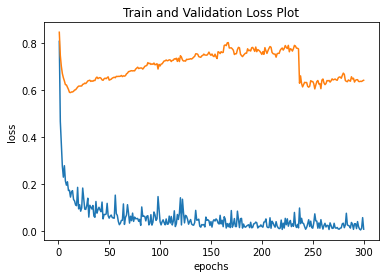

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [ ]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

Presenting the Final Result

In [18]:
test_predictions = np.empty((0,3))
with torch.no_grad():
    for iteration, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = net(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)
        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_y)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_y, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(test_y, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_y, test_predictions))



Predicted Class:
[0 0 1 0 0 2 1 2 1 0 1 1 0 1 2 0 1 1 2 0 0 0 1 0 2 2 2 1 2 2]

Ground Truth:
[0 0 1 0 0 2 1 2 1 0 1 1 0 1 2 0 1 1 2 0 0 0 1 0 2 2 2 1 2 2]


Confusion Matrix:
[[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]


Accuracy: 1.0
F1 Score:  1.0


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

